In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [3]:
from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [4]:
from eppi_text_classification import OptunaHyperparameterOptimisation

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "RandomForestClassifier",
    n_trials_per_job=1,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
    # db_url=f"sqlite:////mnt/tmp/optuna.db", #Use this one on Azure
    db_url=None,
)

optimiser.delete_optuna_study("random_forest_binary")
best_params = optimiser.optimise_hyperparameters(study_name="random_forest_binary")

[I 2024-08-07 19:29:49,440] A new study created in RDB with name: random_forest_binary
[I 2024-08-07 19:29:53,888] Trial 7 finished with value: 0.9219600253098598 and parameters: {'n_estimators': 114}. Best is trial 7 with value: 0.9219600253098598.
[I 2024-08-07 19:29:53,898] Trial 2 finished with value: 0.9006898620541751 and parameters: {'n_estimators': 122}. Best is trial 7 with value: 0.9219600253098598.
[I 2024-08-07 19:29:57,399] Trial 0 finished with value: 0.9244196131325323 and parameters: {'n_estimators': 290}. Best is trial 0 with value: 0.9244196131325323.
[I 2024-08-07 19:29:57,961] Trial 4 finished with value: 0.9397002341339261 and parameters: {'n_estimators': 303}. Best is trial 4 with value: 0.9397002341339261.
[I 2024-08-07 19:29:58,401] Trial 9 finished with value: 0.9405721511194768 and parameters: {'n_estimators': 331}. Best is trial 9 with value: 0.9405721511194768.
[I 2024-08-07 19:30:00,533] Trial 11 finished with value: 0.9229308717072516 and parameters: {'n_e

In [7]:
# FIT THE MODEL

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# model = RandomForestClassifier(**best_params)

model = RandomForestClassifier(class_weight={1: 32}, n_estimators=300)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=7
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight={1: 32}, n_estimators=300)

In [15]:
# CREATE ROC CURVE TO SELECT THRESHOLD

from eppi_text_classification.predict import predict_scores
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_scores(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

In [16]:
# GET MODEL THRESHOLD FOR CHOSEN TPR, MAKE PREDICTIONS

from eppi_text_classification.predict import (
    get_raw_threshold,
    raw_threshold_predict,
)


threshold = get_raw_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = raw_threshold_predict(model, X_test, threshold)
y_train_pred = raw_threshold_predict(model, X_train, threshold)

In [17]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

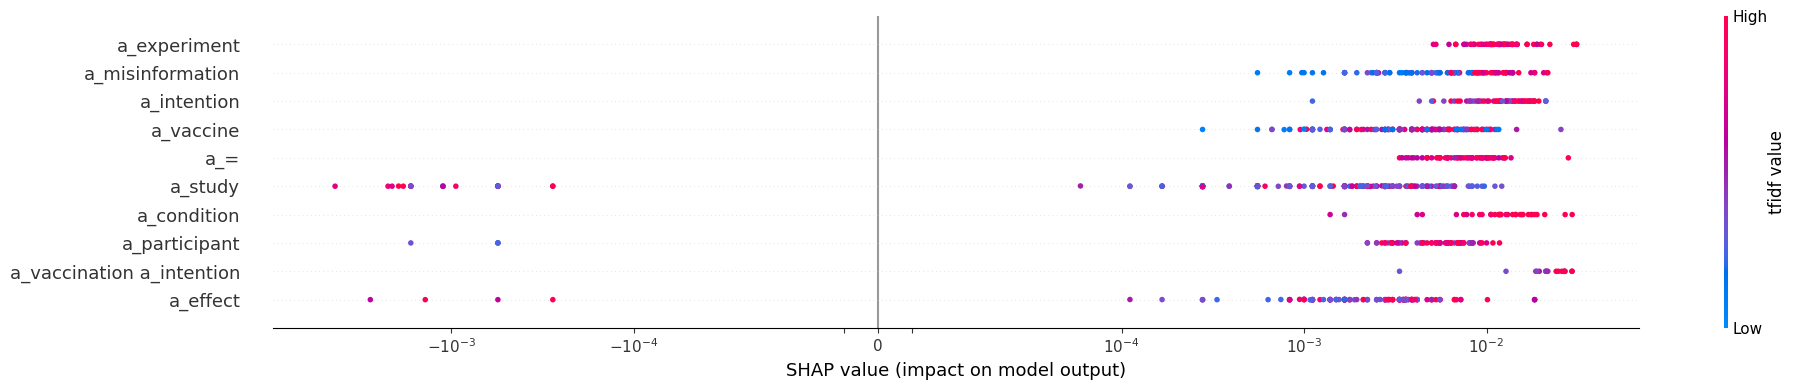

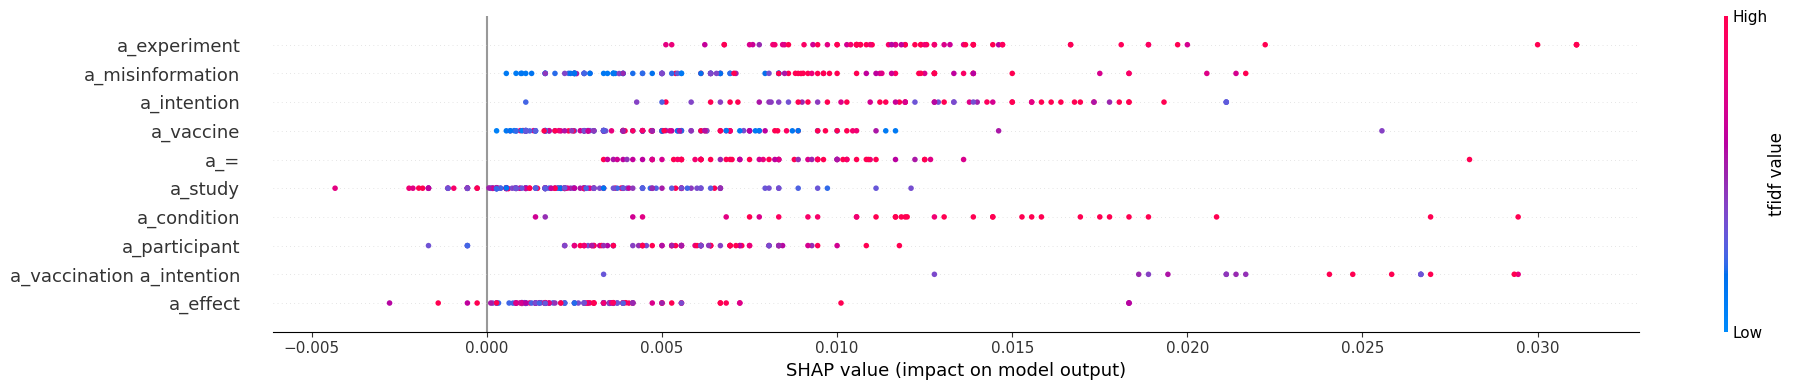

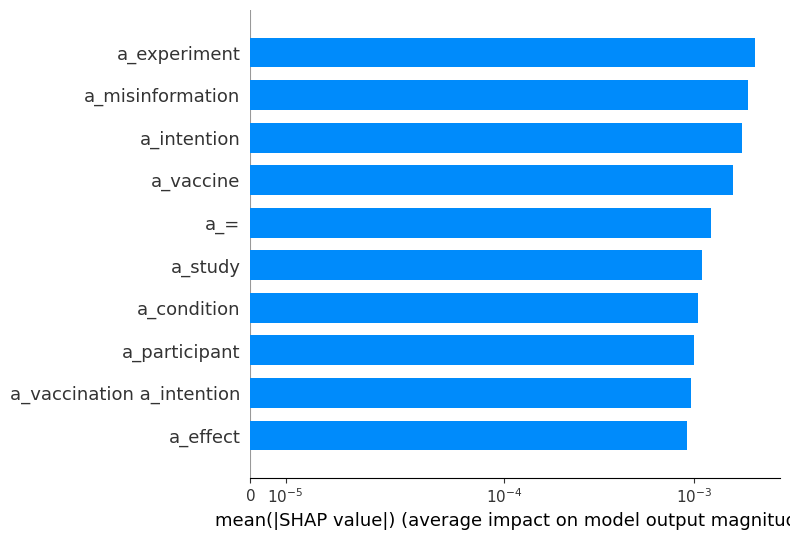

In [21]:
# EXLPAIN THE MODEL

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test, feature_names)

dot_plot = shap_plotter.dot_plot(num_display=10)
dot_plot.show()
dot_plot = shap_plotter.dot_plot(num_display=10, log_scale=False)
dot_plot.show()
bar_plot = shap_plotter.bar_chart()
bar_plot.show()

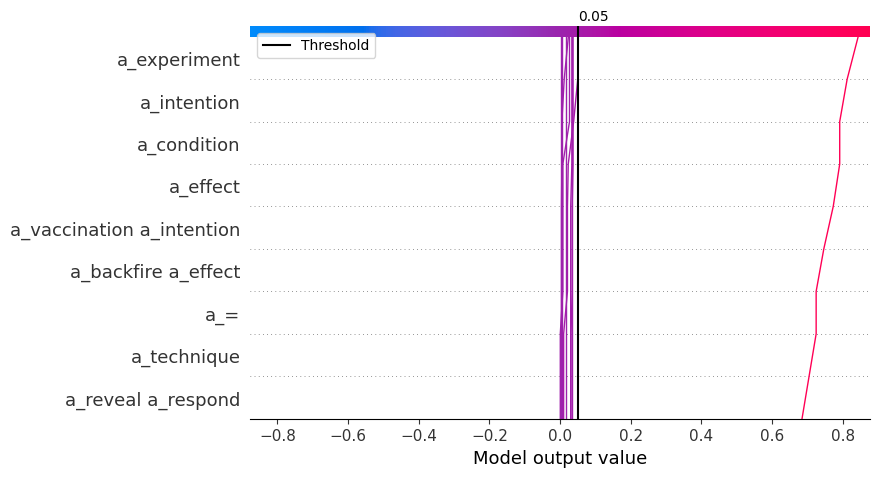

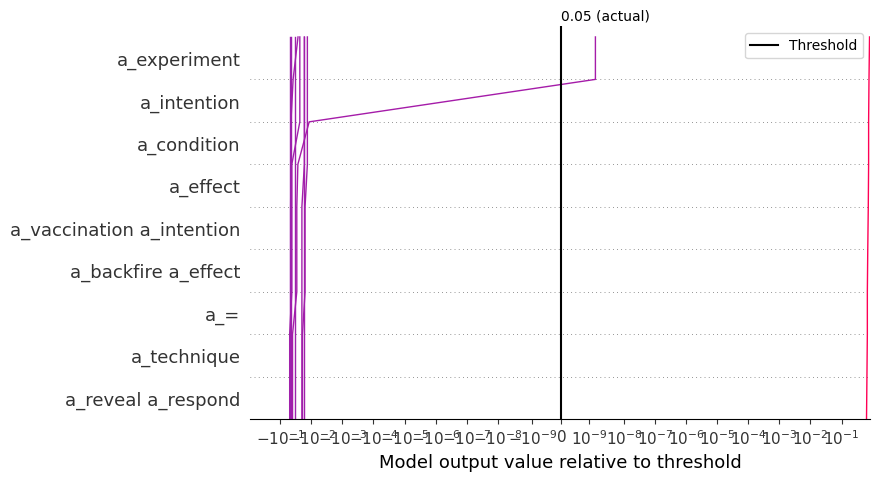

In [23]:
# MAKE THE DECISION PLOTS

from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test[:10], feature_names)

decision_plot = shap_plotter.decision_plot(threshold=threshold, num_display=10)
decision_plot.show()
decision_plot = shap_plotter.decision_plot(
    threshold=threshold, num_display=10, log_scale=True
)
decision_plot.show()

Truth: 0
Prediction: [0]
Shap value: 0.03666666755452752
Prediction score: [0.03666667]


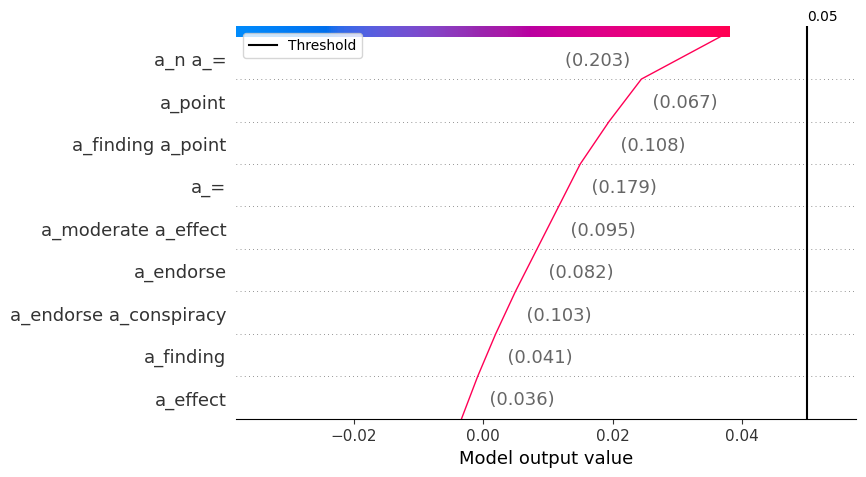

Truth: 1
Prediction: [1]
Shap value: 0.843333353754133
Prediction score: [0.84333333]


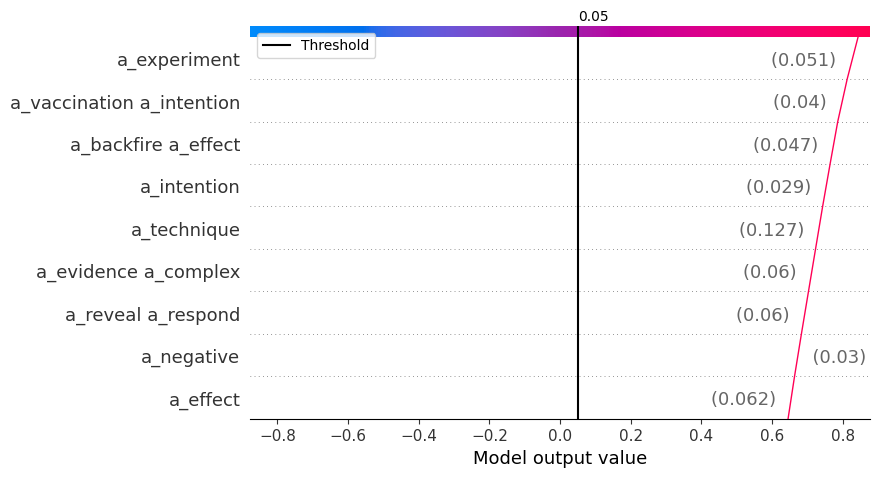

Truth: 0
Prediction: [0]
Shap value: 0.033333334140479565
Prediction score: [0.03333333]


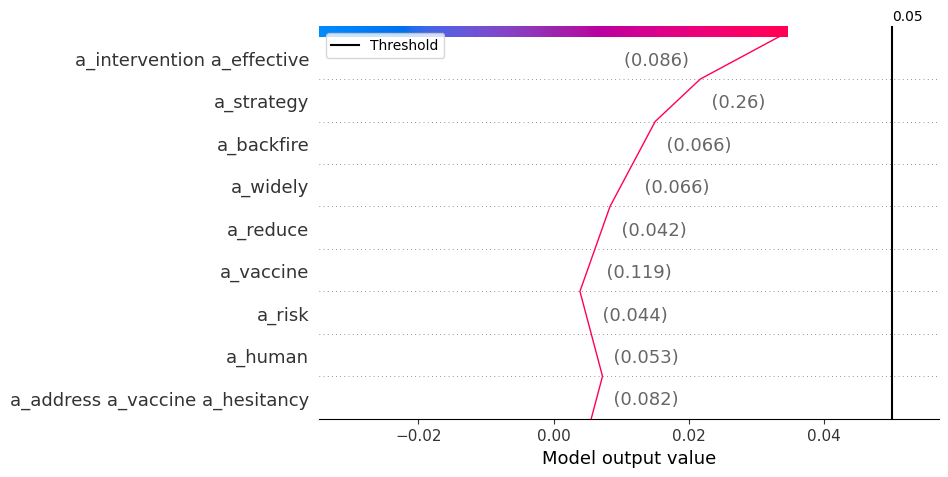

Truth: 0
Prediction: [0]
Shap value: 0.006666666828095913
Prediction score: [0.00666667]


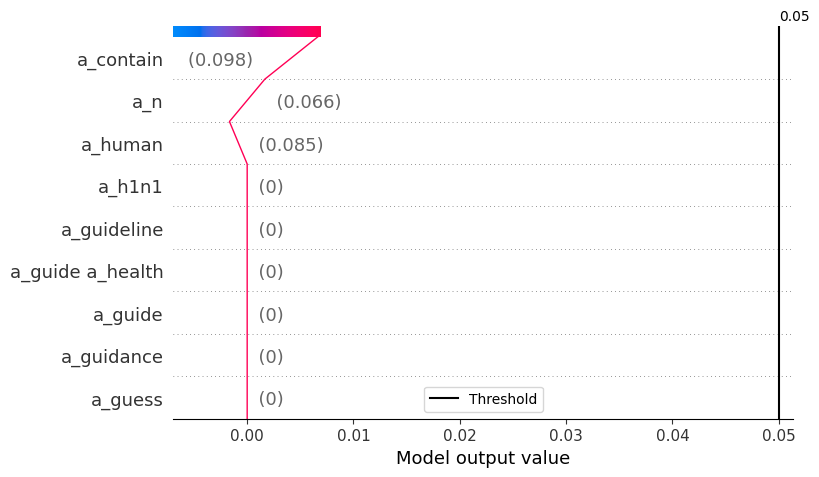

Truth: 0
Prediction: [1]
Shap value: 0.05000000121071935
Prediction score: [0.05]


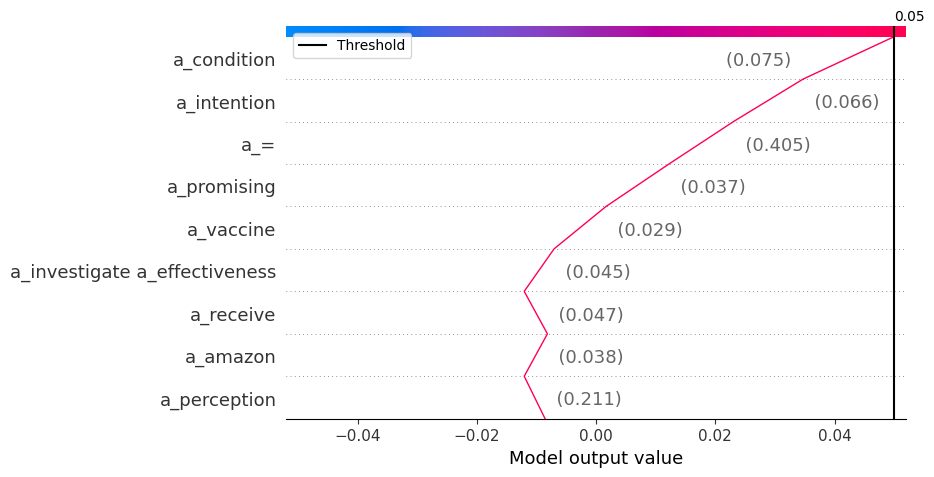

In [25]:
import numpy as np

for i in range(5):
    print(f"Truth: {y_test[i]}")
    print(
        f"Prediction: {raw_threshold_predict(model, np.expand_dims(X_test[i], axis=0), threshold)}"
    )
    print(
        f"Shap value: {np.sum(shap_plotter.shap_values[i]) + shap_plotter.expected_value}"
    )
    print(
        f"Prediction score: {predict_scores(model, np.expand_dims(X_test[i], axis=0))}"
    )
    decision_plot = shap_plotter.single_decision_plot(
        threshold=threshold, index=i, num_display=10, log_scale=False
    )
    decision_plot.show()